In [30]:
import guitarpro
from music21 import instrument, note, stream, chord, duration

import os
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt

from model import NotesRNN

In [3]:
folderpath = "tabs/necro/"

In [14]:
def get_drum_notes(tab):
    
    for track in tab.tracks:
        if track.isPercussionTrack:
            break
    
    notes = []
    for measure in track.measures:
        for beat in measure.voices[0].beats:
            # pass empty measures
            if len(measure.voices[0].beats) == 1 and len(beat.notes) == 0:
                continue
            poly_note = ''
            for note in beat.notes:
                # replace different snare kicks
                if note.value == 40:
                    note.value = 38
                poly_note += str(note.value) + '.'
            notes.append(poly_note)
    
    return notes

In [15]:
notes = []
for filename in os.listdir(folderpath):
    tab = guitarpro.parse(folderpath + filename)
    notes += get_drum_notes(tab)

In [16]:
len(notes)

18233

In [17]:
dictionary = {note: i for i, note in enumerate(set(notes))}
inv_dictionary = {i: note for note, i in dictionary.items()}
notes_to_int = [dictionary[note] for note in notes]
notes_to_int[:10]

[13, 74, 0, 74, 45, 0, 74, 74, 0, 74]

In [18]:
notes[:10]

['46.36.', '42.', '', '42.', '51.38.', '', '42.', '42.', '', '42.']

In [21]:
len(dictionary)

174

In [20]:
def prepare_sequences(notes, dict_size, length, step):
    sequences = []
    targets = []
    for i in range(0, len(notes) - length, step):
        sequences.append(notes[i: i + length])
        targets.append(notes[i + length])
    targets = to_categorical(targets, dict_size)
    return sequences, targets

In [22]:
X, y = prepare_sequences(notes_to_int, len(dictionary), 32, 1)

In [23]:
RNN = NotesRNN(len(dictionary), 100, 256, 2, False, True)

In [24]:
RNN.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    17400       input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 256)    365568      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 256)    525312      lstm[0][0]                       
______________________________________________________________________________________________

In [25]:
X = np.array(X)
y = np.array(y)

In [26]:
RNN.model.fit(
    X, y,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

Epoch 1/20
455/455 [==============================] - 36s 76ms/step - loss: 2.9647 - val_loss: 2.6314
Epoch 2/20
455/455 [==============================] - 33s 72ms/step - loss: 2.5329 - val_loss: 2.5696
Epoch 3/20
455/455 [==============================] - 33s 72ms/step - loss: 2.4341 - val_loss: 2.5672
Epoch 4/20
455/455 [==============================] - 33s 73ms/step - loss: 2.3669 - val_loss: 2.5198
Epoch 5/20
455/455 [==============================] - 34s 74ms/step - loss: 2.2822 - val_loss: 2.5307
Epoch 6/20
455/455 [==============================] - 33s 72ms/step - loss: 2.1821 - val_loss: 2.5360
Epoch 7/20
455/455 [==============================] - 31s 69ms/step - loss: 2.1182 - val_loss: 2.5890
Epoch 8/20
455/455 [==============================] - 29s 64ms/step - loss: 2.0288 - val_loss: 2.6039
Epoch 9/20
455/455 [==============================] - 29s 64ms/step - loss: 1.9201 - val_loss: 2.6546
Epoch 10/20
455/455 [==============================] - 31s 67ms/step - loss: 1.807

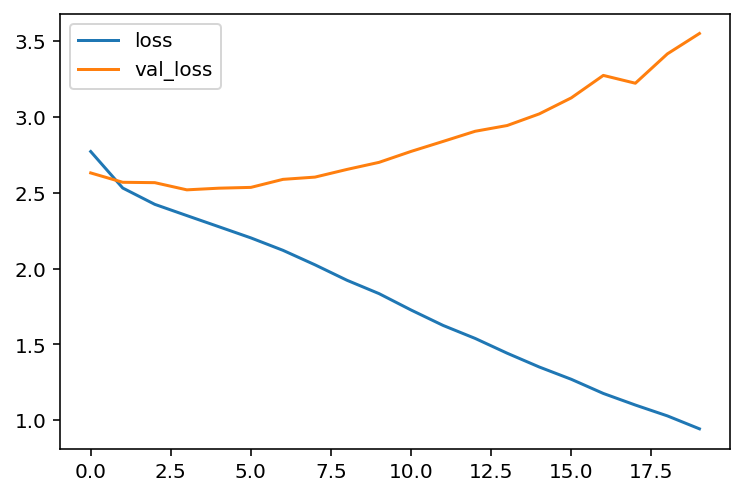

In [32]:
plt.figure()
plt.plot(RNN.model.history.history['loss'], label='loss')
plt.plot(RNN.model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [33]:
def sample(preds, temperature):
    if temperature == 0:
        return np.argmax(preds)
    else:
        preds = np.log(preds) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.random.choice(len(preds), p=preds)

In [34]:
temperature = 0.1
generated = notes_to_int[:32]

for i in tqdm(range(100)):
    preds = RNN.model.predict(generated[i:])[0]
    generated.append(sample(preds, temperature))

  0%|          | 0/100 [00:00<?, ?it/s]

In [37]:
generated_to_notes = [inv_dictionary[i] for i in generated]
generated_to_notes[32:40]

['44.38.', '44.38.', '', '44.38.', '44.38.', '', '44.38.', '44.38.']

In [51]:
midi_stream = stream.Stream()

for gen_notes in generated_to_notes:
    
    gen_notes = gen_notes.split('.')[:-1]
    # chord
    if len(gen_notes) > 1:
        cur_chord = []
        for cur_note in gen_notes:
            new_note = note.Note(int(cur_note))
            new_note.duration = duration.Duration(type='16th')
            new_note.soredInstrument = instrument.Percussion()
            cur_chord.append(new_note)
        midi_stream.append(chord.Chord(cur_chord))
    elif gen_notes != []:
        new_note = note.Note(int(gen_notes[0]))
        new_note.duration = duration.Duration(type='16th')
        new_note.soredInstrument = instrument.Percussion()
        midi_stream.append(new_note)
    else:
        new_note = note.Rest()
        new_note.duration = duration.Duration(type='16th')
        new_note.storedInstrument = instrument.Violoncello()
        midi_stream.append(new_note)
        
midi_stream = midi_stream.chordify()

In [53]:
midi_stream.write('midi', fp=os.path.join('output' + '.mid'))

'output.mid'